# Opening Notes

This notebook is built upon its counterpart in the `NN_ensemble` folder, and the only difference between the two versions is that this notebook allows a specified amount of dropout to be applied to the training, validation and testing stages of the ensembling process.

All the code contained in this notebook, from training to plot generation, can be run using a single line of Unix commands:

```python d_assess_ensemble.py 0.20```

Here, `0.20` stands for the amount of dropout we wish to apply to the training, validation and testing stages of the ensembling. To examine different amounts of dropout at the same time, please use the batch file `submit_ensemble_fitting.sh`, to run multiple instances of `d_assess_ensemble.py` with different dropout values in parallel.

To do this, open a terminal, change the working directory to the this folder, and type in the terminal

```
module load esslurm
sbatch submit_ensemble_fitting.sh
```

# Initialization

Please specify here the amount of dropout you wish to apply to the training, validation and testing stages of the ensembling. A default value of 0.20 is used here.

In [1]:
dropout_amount = 0.20
dropout_int = int(dropout_amount * 100)

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [2]:
import torch
import os, sys

# Find and use the appropriate GPU/CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed data from the caches that we generated with the `../../preprocessing/sdt/gasdb/create_sdt.py` and `../../preprocessing/split_data_gasdb.ipynb` files.

In [3]:
import pickle

# Label to use for this model in the plots
model_name = 'CGCNN ensemble'

# Load the data split from our Jupyter notebook cache
with open('../../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

# Train

It takes a few hours to fit the 5-model ensemble. Since we have to repeat the same fitting process for multiple dropout levels, we used a Python script and submitted it as a "job" on our high-performing-computer center via `sbatch submit_ensemble_fitting_dropout.sh`. 

Since we examined 7 distinct dropout levels, we intend to run 7 parallel fitting processes.

Here is what the Python script contains.

```
#!/usr/bin/env python
# coding: utf-8

# Initialization
import torch
import pickle
import numpy as np
from sklearn.model_selection import KFold
from torch.optim import Adam
import skorch.callbacks.base
from skorch.callbacks import Checkpoint  # needs skorch >= 0.4
from skorch.callbacks.lr_scheduler import LRScheduler
from skorch import NeuralNetRegressor
from cgcnn.dropoutmodel import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Update dropout value with input
if dropout_amount != 0:
    CrystalGraphConvNet.update_dropout(True, dropout_amount)


# Find and use the appropriate GPU/CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')


# Load the data split from our Jupyter notebook cache
model_name = 'CGCNN ensemble'

with open('../../preprocessing/sdt/cathub/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../../preprocessing/splits_cathub.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./histories/%i_d%i_valid_best_params.pt' % (k, dropout_int))

nets = []


# Fold the CV data and train
k_folder = KFold(n_splits=5)
for k, (indices_train, _) in enumerate(k_folder.split(sdts_train)):
    stds_train_ = [sdts_train[index] for index in indices_train]
    targets_train_ = np.array([targets_train[index] for index in indices_train])

    # Define various callbacks and checkpointers for this network
    LR_schedule = LRScheduler('MultiStepLR', milestones=[75], gamma=0.1)
    cp = Checkpoint(monitor='valid_loss_best', fn_prefix='./histories/%i_d%i_valid_best_' % (k, dropout_int))
    load_best_valid_loss = train_end_load_best_valid_loss()

    # Train this fold's network
    net = NeuralNetRegressor(
        CrystalGraphConvNet,
        module__orig_atom_fea_len=orig_atom_fea_len,
        module__nbr_fea_len=nbr_fea_len,
        batch_size=214,
        module__classification=False,
        lr=0.0056,
        max_epochs=100,
        module__atom_fea_len=46,
        module__h_fea_len=83,
        module__n_conv=8,
        module__n_h=4,
        optimizer=Adam,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=0,
        iterator_train__collate_fn=collate_pool,
        iterator_train__shuffle=True,
        iterator_valid__pin_memory=True,
        iterator_valid__num_workers=0,
        iterator_valid__collate_fn=collate_pool,
        iterator_valid__shuffle=False,
        device=device,
        criterion=torch.nn.L1Loss,
        dataset=MergeDataset,
        callbacks=[cp, load_best_valid_loss, LR_schedule]
    )
    net.initialize()
    net.fit(stds_train_, targets_train_)
    nets.append(net)
```

Other than variable name changes, the only difference between the code below and its counterpart in the unmodified `../CGCNN_ensemble/assess_ensemble.ipynb`, is the use of the `cgcnn.dropoutmodel` module, as opposed to the `cgcnn.model` module. The name of the module used here suggests that a dropout is always applied during training and testing.

# Loading models
We load the parameters generated from the long training process here.

This requires a modified version of the CGCNN package, which is available at `https://github.com/ulissigroup/cgcnn/tree/dropout`.  We assume this version of the CGCNN module is installed under the `$HOME/cgcnn` directory. If this is not the case, please modify the first line in the cell below to the directory where CGCNN is installed.

In [5]:
sys.path.append(os.path.expanduser("~/cgcnn"))

import numpy as np
from sklearn.model_selection import KFold
from torch.optim import Adam
import skorch.callbacks.base
from skorch.callbacks import Checkpoint  # needs skorch >= 0.4
from skorch.callbacks.lr_scheduler import LRScheduler
from skorch import NeuralNetRegressor
from cgcnn.olddropoutmodel import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Update dropout value with input
if dropout_amount != 0:
    CrystalGraphConvNet.update_dropout(True, dropout_amount)

    
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./histories/%i_d%i_valid_best_params.pt' % (k, dropout_int))


nets = []
# Fold the CV data
k_folder = KFold(n_splits=5)
for k, (indices_train, _) in enumerate(k_folder.split(sdts_train)):
    stds_train_ = [sdts_train[index] for index in indices_train]
    targets_train_ = np.array([targets_train[index] for index in indices_train])

    # Define various callbacks and checkpointers for this network
    LR_schedule = LRScheduler('MultiStepLR', milestones=[75], gamma=0.1)
    cp = Checkpoint(monitor='valid_loss_best', fn_prefix='./histories/%i_d%i_valid_best_' % (k, dropout_int))
    load_best_valid_loss = train_end_load_best_valid_loss()

    # Train this fold's network
    net = NeuralNetRegressor(
        CrystalGraphConvNet,
        module__orig_atom_fea_len=orig_atom_fea_len,
        module__nbr_fea_len=nbr_fea_len,
        batch_size=214,
        module__classification=False,
        lr=0.0056,
        max_epochs=100,
        module__atom_fea_len=46,
        module__h_fea_len=83,
        module__n_conv=8,
        module__n_h=4,
        optimizer=Adam,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=0,
        iterator_train__collate_fn=collate_pool,
        iterator_train__shuffle=True,
        iterator_valid__pin_memory=True,
        iterator_valid__num_workers=0,
        iterator_valid__collate_fn=collate_pool,
        iterator_valid__shuffle=False,
        device=device,
        criterion=torch.nn.L1Loss,
        dataset=MergeDataset,
        callbacks=[cp, load_best_valid_loss, LR_schedule]
    )
    net.initialize()
    net.load_params(f_history='./histories/%i_d%i_valid_best_history.json' % (k, dropout_int),
                    f_optimizer= './histories/%i_d%i_valid_best_optimizer.pt' % (k, dropout_int), 
                    f_params='./histories/%i_d%i_valid_best_params.pt' % (k, dropout_int))
    nets.append(net)

# Ensembling
The definition of the `Ensemble()` method here differs from that of its counterpart in the unmodified `../CGCNN_ensemble/assess_ensemble.ipynb`, in that for each of the 5 networks in the ensemble, the `net.predict()` function is used 100 times. In other words, we have $500 = 5\times 100$ predictions to sample from, rather than the 5 samples in the original.

In [6]:
class Ensemble:
    def __init__(self, networks):
        self.networks = networks

    def predict(self, features, iters):
        for i, net in enumerate(self.networks):
            for _ in range(iters):
                prediction = net.predict(features)
                try:
                    predictions = np.hstack((predictions, prediction))
                except NameError:
                    predictions = prediction
            print('Net %i finished training.' % i)

        return predictions

iters = 100 # Use net.predict() 100 times for every use of net.fit()


The original definition of the `Ensemble()` method is given here for comparison.

In [7]:
class OldEnsemble:
    def __init__(self, networks):
        self.networks = networks

    def predict(self, features):
        # Make the prediction for this network
        for net in self.networks:
            prediction = net.predict(features)

            # Concatenate this network's predictions with the previous ones
            try:
                predictions = np.hstack((predictions, prediction))

            # If this is the first network to make predictions,
            # then initialize the `predictions` output
            except NameError:
                predictions = prediction
        return predictions

# Assess Performance

In [8]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

## Validation

In [9]:
# Make the predictions
ensemble = Ensemble(nets)
predy_val = ensemble.predict(sdts_val, iters)

Net 0 finished training.
Net 1 finished training.
Net 2 finished training.
Net 3 finished training.
Net 4 finished training.


### Parity Plot

R2 = 0.82
PPMCC = 0.91


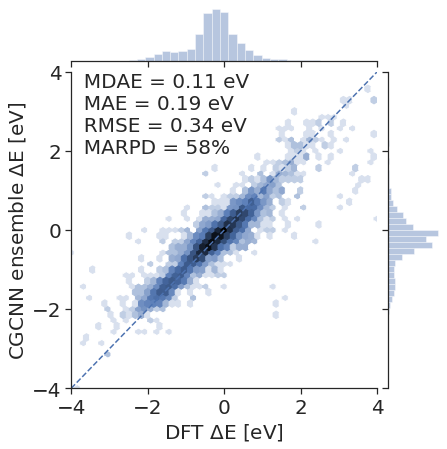

In [10]:
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Make the predictions
targets_pred = predy_val.mean(axis=1)
residuals = targets_pred - targets_val.reshape(-1)
stdevs = predy_val.std(axis=1)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_val.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

In [ ]:
targets_val.reshape(-1).shape

In [11]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the center
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    lower_bound = norm.ppf(0.5-percentile/2)
    upper_bound = norm.ppf(0.5+percentile/2)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [12]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

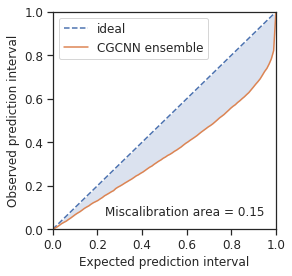

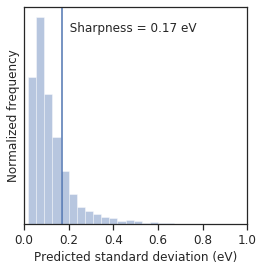

In [13]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (width, width)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)


# Plot sharpness curve
xlim = [0, 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviation (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

## Test
### Parity Plot

In [14]:
# Make the predictions
ensemble = Ensemble(nets)
predy_test = ensemble.predict(sdts_test, iters)

Net 0 finished training.
Net 1 finished training.
Net 2 finished training.
Net 3 finished training.
Net 4 finished training.


In [15]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.82
PPMCC = 0.91


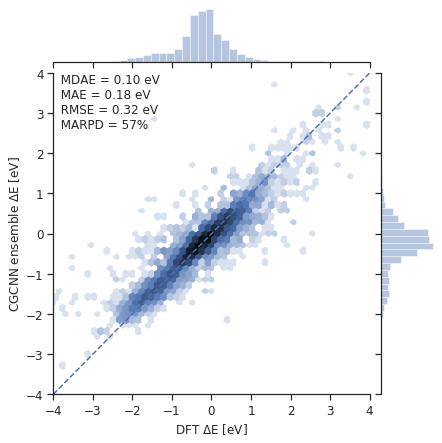

In [16]:
%matplotlib inline
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)
import matplotlib.pyplot as plt
import seaborn as sns


# Make the predictions
targets_pred = predy_test.mean(axis=1)
residuals = targets_pred - targets_test.reshape(-1)
stdevs = predy_test.std(axis=1)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_test.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_test, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_test, targets_pred))
mdae = median_absolute_error(targets_test, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_test.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_test, targets_pred)
corr = np.corrcoef(targets_test.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

# Save figure
plt.savefig('parity.pdf', dpi=300, bbox_inches='tight', transparent=True)

### Calibration Curves

NameError: name 'standard_errors' is not defined

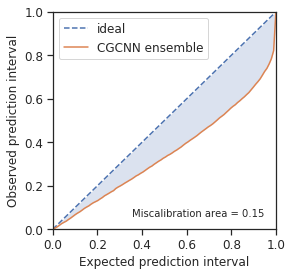

<Figure size 288x288 with 0 Axes>

In [17]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')

# Save
plt.savefig('calibration.pdf', dpi=300, bbox_inches='tight', transparent=True)


# Plot sharpness curve
xlim = [0, 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(standard_errors, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviation (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(standard_errors**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align)

# Save
# plt.savefig('sharpness.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (width, width)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)


# Plot sharpness curve
xlim = [0, 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviation (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

# Error-bar figure
We concede that calibration curves and sharpness distributions are new concepts in the field of catalysis, and that a simple parity plot with error bars is more intuitive. As such, we create a few examples of error bar parities to help readers connect those incumbent ideas with the newer ideas of calibration and sharpness.

In [ ]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt


# Pull a random sample of the data, because plotting thousands of these at once would look absurd
all_predictions = list(zip(targets_pred, targets_test.reshape(-1), stdevs))
samples = random.sample(all_predictions, k=20)

# Parse the samples
_preds, _targets, _stdevs = zip(*samples)
_preds = np.array(_preds)
_targets = np.array(_targets)
_stdevs = np.array(_stdevs)

# Plot
fig = plt.figure(figsize=(4, 4))
_ = plt.errorbar(_targets, _preds, yerr=2*_stdevs, fmt='o')
ax = plt.gca()

# Make a parity line
lims = [-2, 2]
_ = ax.plot(lims, lims, '--')

# Format
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.set_xticks(list(range(-2, 3)))
_ = ax.set_yticks(list(range(-2, 3)))
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Save
_ = plt.savefig('error_bar_parity.pdf', dpi=300, bbox_inches='tight', transparent=True)

## Saving the data
We need to save the prediction data with the `pickle` module, so we can compare the effects of different prediction methods and different dropout levels in one plot, using another notebook.

In [ ]:
# Save as pickle to be plotted with in the same graph as others
with open('assess_ensemble_d%i.pkl' % dropout_int, 'wb') as saveplot:
    pickle.dump((predictions, targets_val), saveplot)